# Movie Recommendation

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import matplotlib.style as style
style.use('seaborn-darkgrid')

## DB connect

In [11]:
con = sqlite3.connect("./movies.db")

In [12]:
df = pd.read_sql_query("SELECT * FROM df", con).drop('index',axis=1)
df.head()

,userid,movieid,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## EDA

In [27]:
print('# of Users: ', df.userid.nunique())
print('# of Movies: ', df.title.nunique())
print('rating points: ', df.rating.unique())

# of Users:  610
# of Movies:  9719
rating points:  [4.  4.5 2.5 3.5 3.  5.  0.5 2.  1.5 1. ]


In [13]:
# split movie release years 
df['movie_year'] = df.title.str.extract('.*\((.*)\).*')
df['title'] = df.title.str.split('(').str[0].str[:-1]

<>:2: DeprecationWarning: invalid escape sequence \(
<>:2: DeprecationWarning: invalid escape sequence \(
/var/folders/tb/0nxt_p456gs54x8pwqj510hw0000gp/T/ipykernel_12877/3947413214.py:2: DeprecationWarning: invalid escape sequence \(
  df['movie_year'] = df.title.str.extract('.*\((.*)\).*')


In [14]:
# setting type
df = df.astype({'userid':'int','movieid':'int','rating':'float','timestamp':'int'})

In [15]:
# convert timestamp into readable format
import datetime
from datetime import datetime
def timestamp_Readable(df):
    return pd.to_datetime(datetime.fromtimestamp(df).strftime('%Y-%m-%d %H:%M:%S'))

df.timestamp = df.timestamp.apply(timestamp_Readable)
df.head()

,userid,movieid,rating,timestamp,title,genres,movie_year
0,1,1,4.0,2000-07-31 03:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,1996-11-08 15:36:02,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,2005-01-25 15:52:26,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,2017-11-13 21:59:30,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,2011-05-18 14:28:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [16]:
# decrease # of rating
df.rating = np.ceil(df.rating)
print('Rating points: ', df.rating.unique())

Rating points:  [4. 5. 3. 1. 2.]


In [17]:
# removing movies (rated <= 10)
movieid_val = df.movieid.value_counts()
movie_rating_greater_10 = movieid_val[movieid_val>=10].index
df = df[df.movieid.isin(movie_rating_greater_10)]

### Frequency of the Ratings

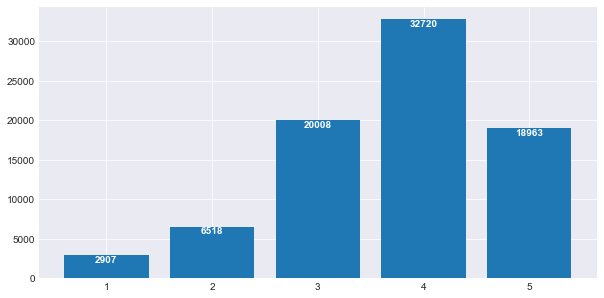

In [13]:
fig = plt.figure(figsize=(10,5))
rc = df.rating.value_counts()
plt.bar(rc.index, rc)
for i,v in zip(rc.index,rc):
    plt.text(i,v,v,color='white', fontweight='bold', va='top', ha='center')    

### Top Frequent Movie Genres

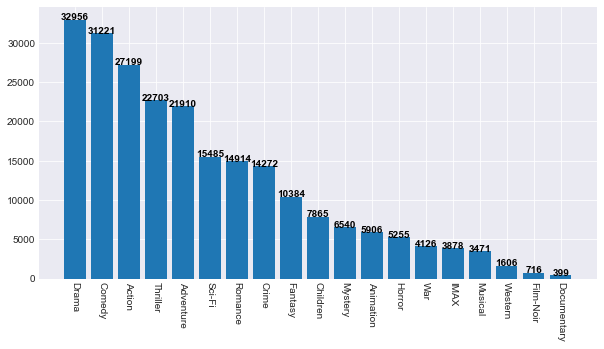

In [14]:
fig = plt.figure(figsize=(10,5))
gc = df.genres.str.split('|', expand=True).stack().value_counts()
plt.bar(gc.index, gc)
for i,v in zip(gc.index,gc):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

### Number of Movies for each Genre

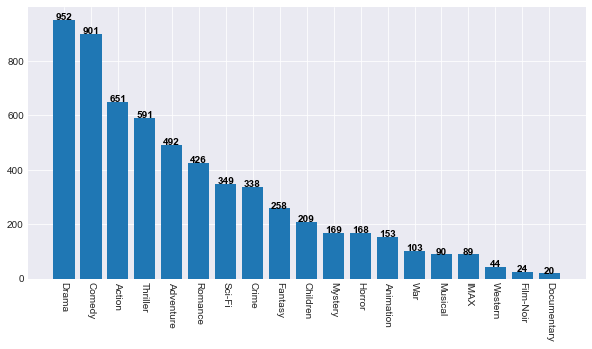

In [15]:
unq_movie = df.drop_duplicates('title')
gc = unq_movie['genres'].str.split('|', expand=True).stack().value_counts()
fig = plt.figure(figsize=(10,5))
plt.bar(gc.index, gc)
for i,v in zip(gc.index,gc):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

### Rating Averages

In [16]:
genre_vs_rating = df.groupby(['genres', 'rating']).size().unstack().fillna(0)
movie_vs_rating = df.groupby(['title', 'rating']).size().unstack().fillna(0)

In [17]:
# Rating Average for dataframe rows
def Rating_Average(df):
    x = []
    for i in range(0, df.shape[0]):
        x.append((np.average(df.iloc[i].index, weights=df.iloc[i].values, axis=0)).round(2))
    return x

# genre_vs_rating rows
genre_vs_rating['rating_average'] = Rating_Average(genre_vs_rating)

# movie_vs_rating rows
movie_vs_rating['rating_average'] = Rating_Average(movie_vs_rating)

In [18]:
movie_vs_rating.head()

rating,1.0,2.0,3.0,4.0,5.0,rating_average
title,,,,,,
,2.0,2.0,6.0,21.0,11.0,3.88
"'burbs, The",2.0,3.0,3.0,6.0,3.0,3.29
10 Cloverfield Lane,0.0,0.0,5.0,7.0,2.0,3.79
10 Things I Hate About You,3.0,2.0,16.0,21.0,12.0,3.69
"10,000 BC",1.0,4.0,8.0,4.0,0.0,2.88


### Top 15 Movie with the highest Rating Averages

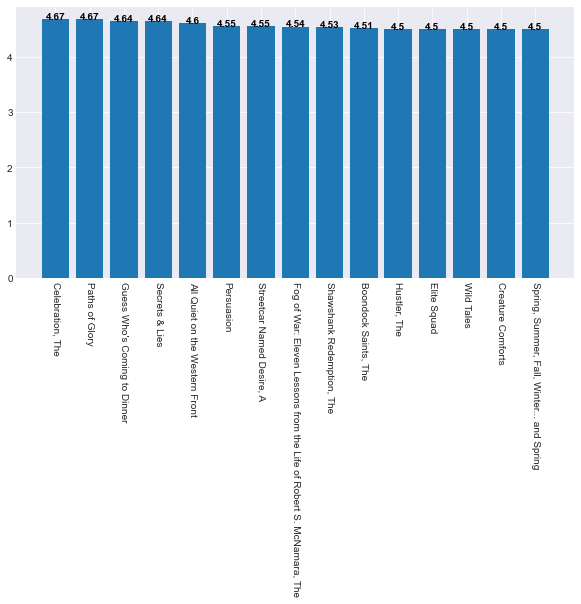

In [19]:
fig = plt.figure(figsize=(10,5))
mv_15 = movie_vs_rating.sort_values('rating_average', ascending=False).iloc[:15,-1]
plt.bar(mv_15.index, mv_15)
for i,v in zip(mv_15.index, mv_15):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

### Top 15 Movie with the smalliest Rating Averages

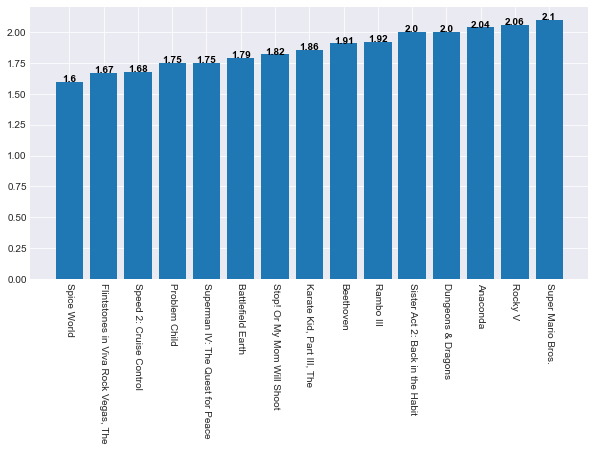

In [20]:
fig = plt.figure(figsize=(10,5))
mv_15 = movie_vs_rating.sort_values('rating_average').iloc[:15,-1]
plt.bar(mv_15.index, mv_15)
for i,v in zip(mv_15.index, mv_15):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

### Top 15 Genres with the highest Rating Averages

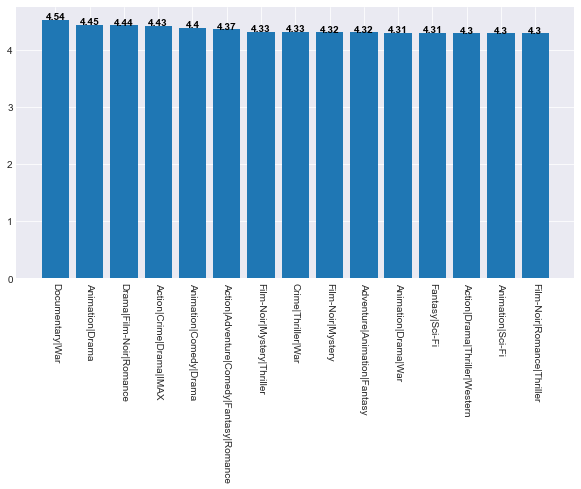

In [21]:
fig = plt.figure(figsize=(10,5))
gv_15 = genre_vs_rating.sort_values('rating_average', ascending=False).iloc[:15,-1]
plt.bar(gv_15.index, gv_15)
for i,v in zip(gv_15.index, gv_15):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

### Top 15 Genres with the smalliest Rating Averages

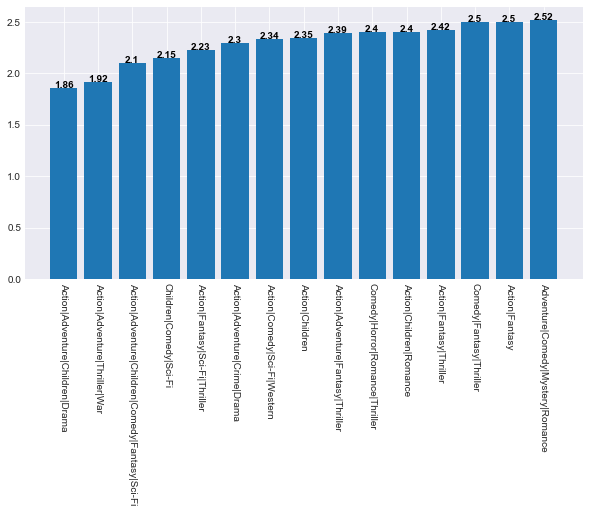

In [22]:
fig = plt.figure(figsize=(10,5))
gv_15 = genre_vs_rating.sort_values('rating_average').iloc[:15,-1]
plt.bar(gv_15.index, gv_15)
for i,v in zip(gv_15.index, gv_15):
    plt.text(i,v,v,color='black', fontweight='bold', ha='center') 
plt.xticks(rotation=270)
plt.show()

## Apriori Algorithm Application

“X 아이템을 구매하는 고객들은 Y 아이템 역시 구매할 가능성이 높다”는 식의 결론을 내는 알고리즘

In [18]:
# Created a (movieid: title) dictionary for all movieId's for replacing them with their names
movieid_dict = df.drop_duplicates('title')[['movieid', 'title']].set_index('movieid').to_dict()['title']

# Creating a pivot table that has indexes as user ratings, and columns as each movie title
dataRecommendation = df.pivot(index='userid', columns='movieid', values='rating').fillna(0)

# Replacing dataRecommendation columns with the movie titles
dataRecommendation.columns = dataRecommendation.columns.map(movieid_dict)

dataRecommendation.head(10)

movieid,Toy Story,Jumanji,Grumpier Old Men,Father of the Bride Part II,Heat,Sabrina,Sudden Death,GoldenEye,"American President, The",Dracula: Dead and Loving It,...,Moana,Rogue One: A Star Wars Story,Hidden Figures,Get Out,Logan,Dunkirk,Blade Runner 2049,Coco,Star Wars: The Last Jedi,Deadpool 2
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,5.0,4.0,4.0,0.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def encode_units(k):
    if k <= 0:
        return 0
    if k >= 1:
        return 1


sets = dataRecommendation.applymap(encode_units)
sets.astype(int)
sets.head()

movieid,Toy Story,Jumanji,Grumpier Old Men,Father of the Bride Part II,Heat,Sabrina,Sudden Death,GoldenEye,"American President, The",Dracula: Dead and Loving It,...,Moana,Rogue One: A Star Wars Story,Hidden Figures,Get Out,Logan,Dunkirk,Blade Runner 2049,Coco,Star Wars: The Last Jedi,Deadpool 2
userid,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
!pip install apyori
!pip install mlxtend

In [20]:
# Applying Apriori algorithm to matrix
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Applying Apriori algorithm to matrix that we created before (userId-movieId) and setting min support as 0.15
frequent_itemsets = apriori(sets, min_support=0.15, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.75).sort_values('lift', ascending=False)

rules = rules[['antecedents', 'consequents', 'support', 'lift', 'confidence']]
rules.head()

/Users/jayoung/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,lift,confidence
14099,(Star Wars: Episode V - The Empire Strikes Bac...,"(Star Wars: Episode IV - A New Hope, Matrix, T...",0.154098,4.873364,0.886792
14082,"(Star Wars: Episode IV - A New Hope, Matrix, T...",(Star Wars: Episode V - The Empire Strikes Bac...,0.154098,4.873364,0.846847
14070,(Lord of the Rings: The Fellowship of the Ring...,(Star Wars: Episode V - The Empire Strikes Bac...,0.154098,4.799130,0.912621
14111,(Star Wars: Episode V - The Empire Strikes Bac...,(Lord of the Rings: The Fellowship of the Ring...,0.154098,4.799130,0.810345
14098,(Star Wars: Episode V - The Empire Strikes Bac...,"(Star Wars: Episode IV - A New Hope, Lord of t...",0.154098,4.794314,0.903846


### Examples of Apriori Rules

In [27]:
import random
i = random.randint(0, rules.shape[0])
print('Antecedents:', rules.iloc[i].antecedents)
print('Consequents:', rules.iloc[i].consequents)
print(f'Lift: {rules.iloc[i].lift.round(3)} & Confidence: {rules.iloc[i].confidence.round(3)}')

Antecedents: frozenset({'Sixth Sense, The'})
Consequents: frozenset({'Fight Club'})
Lift: 2.001 & Confidence: 0.715


In [28]:
i = random.randint(0, rules.shape[0])
print('Antecedents:', rules.iloc[i].antecedents)
print('Consequents:', rules.iloc[i].consequents)
print(f'Lift: {rules.iloc[i].lift.round(3)} & Confidence: {rules.iloc[i].confidence.round(3)}')

Antecedents: frozenset({'Forrest Gump', 'Apollo 13', 'Jurassic Park'})
Consequents: frozenset({'Fugitive, The'})
Lift: 2.389 & Confidence: 0.744


### Movie Recommendation

In [21]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(dataRecommendation.values.T)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=11)

In [22]:
def movie_recommendation(movie_name, num_of_recommendations):
    a = dataRecommendation.columns.to_frame().reset_index(drop=True).to_dict()['movieid']
    recommendation_result = list(knn.kneighbors([dataRecommendation[movie_name].values], num_of_recommendations + 1))
    recommendation_result = pd.DataFrame(np.vstack((recommendation_result[1], recommendation_result[0])),
                                         index=['movieid', 'Cosine_Similarity (degree)']).T
    recommendation_result = recommendation_result.drop([0]).reset_index(drop=True)
    recommendation_result.movieid = recommendation_result.movieid.map(a)
    return recommendation_result

In [ ]:
movie_recommendation('Mulan', 7)